# Import Packages

In [1]:
from astropy.io import fits
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
from astropy.convolution import convolve as ap_convolve
from astropy.convolution import Box2DKernel
plt.style.use(astropy_mpl_style)
import numpy as np
import scipy.stats as st
import math
import scipy
from scipy.ndimage import gaussian_filter
import time

# Define functions

In [2]:
def add_noise(im, sigma):
    #im: image to which noise will be added, must be a np array
    #sigma: noise standard deviation
    
    shape = im.shape
    noise = np.random.normal(0, sigma, size = shape)
    
    return im+noise

def NESMA_filtering(raw,txy,tz,thresh,verbose=False):
    #Inputs:
    # raw    : 4D (x,y,z,MS) raw/noisy volume. x,y and z/slice are the spatial coordinates, while MS is the multispectral dimension
    # txy    : Defines the size, (2*txy+1)-by-(2*txy+1) in voxels, of the search window in the x-y plane.
    # tz     : Defines the size, (2*tz+1) in voxels, of the search window in the z direction (a.k.a slice direction).
    # thresh : 100%-thresh defines the similarity threshold (%). Values between 1% to 10% are recommended.

    # Output:
    # S_NESMA: 4D (x,y,z,MS) NESMA-filtered volume
    
    (m,n,o,p) = raw.shape
    S_NESMA = np.zeros((m,n,o,p))
    
    for k in trange(o):
        if verbose==True:
            print('NESMA filtering ... Slice #', k, 'of', o)
        for i in range(m):
            for j in range(n):
                if raw[i,j,k,0]>10:
                    rmin=max(i-txy,0)
                    rmax=min(i+txy,m)
                    
                    smin=max(j-txy,0)
                    smax=min(j+txy,n)
                    
                    tmin=max(k-tz,0)
                    tmax=min(k+tz,o)
                    
                    L = (rmax-rmin)*(smax-smin)*(tmax-tmin)
                    
                    rawi = np.reshape(raw[rmin:rmax,smin:smax,tmin:tmax,:],(L,p))
                    x=raw[i,j,k,:]
                    
                    D = 100*np.sum(abs(rawi-x),axis=1)/np.sum(x)
                    pos = D<thresh
                    
                    S_NESMA[i,j,k,:] = np.mean(rawi[pos==True, :], axis=0)
                    
    return S_NESMA

def NESMA_filtering_3D(raw,txy,thresh,verbose=False):
    #Inputs:
    # raw    : 3D (x,y,MS) raw/noisy volume. x,y are the spatial coordinates, while MS is the multispectral dimension
    # txy    : Defines the size, (2*txy+1)-by-(2*txy+1) in voxels, of the search window in the x-y plane.
    # thresh : 100%-thresh defines the similarity threshold (%). Values between 1% to 10% are recommended.

    # Output:
    # S_NESMA: 3D (x,y,MS) NESMA-filtered volume
    
    (m,n,o) = raw.shape
    S_NESMA = np.zeros((m,n,o))
    
    for j in range(n):
        if verbose==True and j%50==0:
            print('NESMA filtering ... Slice #', j, 'of', n)
        for i in range(m):
            rmin=max(i-txy,0)
            rmax=min(i+txy,m)
                    
            smin=max(j-txy,0)
            smax=min(j+txy,n)
                    
            L = (rmax-rmin)*(smax-smin)
                    
            rawi = np.reshape(raw[rmin:rmax,smin:smax,:],(L,o))
            x=raw[i,j,:]
                    
            D = 100*np.sum(abs(rawi-x),axis=1)/np.sum(x)
            pos = D<thresh
                    
            S_NESMA[i,j,:] = np.mean(rawi[pos==True,:], axis=0)
    
    return S_NESMA

# Test NESMA on a 3-channel image

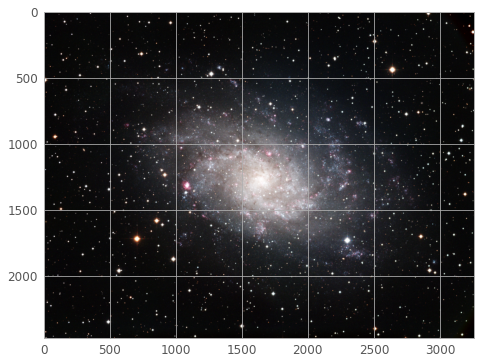

In [6]:
hdul = fits.open('W:\\Nonlocal Filter Project\Test images\M33_RGB_Result_no_NR.fit')
M33 = np.flip(hdul[0].data,axis=0)
M33 = np.moveaxis(M33, 0, 2)
M33[:,:,[0,2]]=M33[:,:,[2,0]]
plt.figure()
plt.imshow(M33, cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


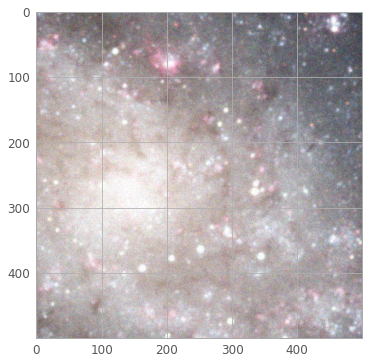

In [7]:
M33_subset = M33[1000:1500,1500:2000,:]
M33_subsetR = add_noise(M33_subset[:,:,0],0.05)
M33_subsetG = add_noise(M33_subset[:,:,1],0.05)
M33_subsetB = add_noise(M33_subset[:,:,2],0.05)
M33_subset = np.stack((M33_subsetR, M33_subsetG, M33_subsetB), axis=-1)
plt.imshow(M33_subset)

In [8]:
thresh = 10
txy = 5
NESMA_output = NESMA_filtering_3D(M33_subset, txy, thresh, verbose=True)

NESMA filtering ... Slice # 0 of 500
NESMA filtering ... Slice # 50 of 500
NESMA filtering ... Slice # 100 of 500
NESMA filtering ... Slice # 150 of 500
NESMA filtering ... Slice # 200 of 500
NESMA filtering ... Slice # 250 of 500
NESMA filtering ... Slice # 300 of 500
NESMA filtering ... Slice # 350 of 500
NESMA filtering ... Slice # 400 of 500
NESMA filtering ... Slice # 450 of 500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


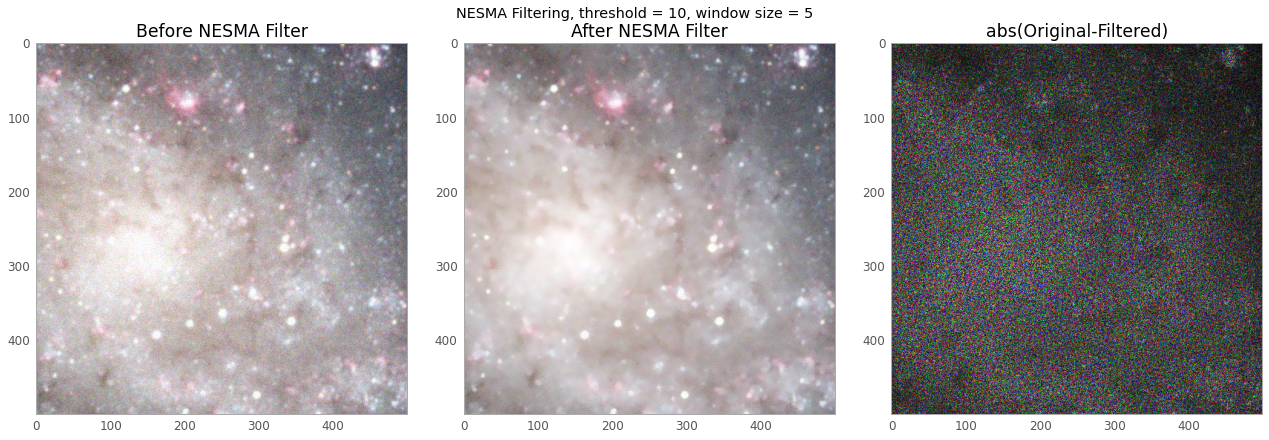

In [11]:
difference = abs(M33_subset-NESMA_output)
difference = 2*10**5*(difference/difference.sum())

fig, ax = plt.subplots(1,3, figsize = (18, 6), tight_layout=True)
fig.suptitle('NESMA Filtering, threshold = %s, window size = %s' % (thresh, txy))
ax[0].imshow(M33_subset)
ax[0].set_title('Before NESMA Filter')
ax[0].grid()
ax[1].imshow(NESMA_output)
ax[1].set_title('After NESMA Filter')
ax[1].grid()
ax[2].imshow((difference))
ax[2].set_title('abs(Original-Filtered)')
ax[2].grid()
plt.show()

# Test NESMA on a 6-channel image

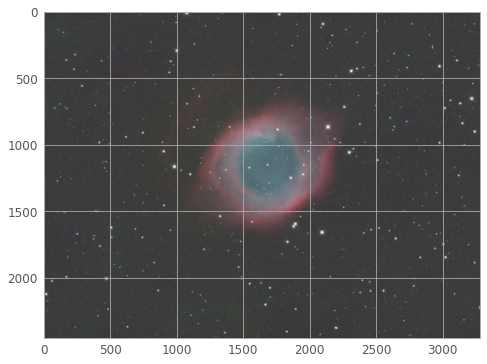

In [58]:
hdulR = fits.open(r'W:\Nonlocal Filter Project\Test images\Individual channels after simple stretch\NGC7293_Helix_MASTER_Red_DBE_stretched.fit')
HelixR = hdulR[0].data#np.flip(hdulR[0].data,axis=0)

hdulG = fits.open(r'W:\Nonlocal Filter Project\Test images\Individual channels after simple stretch\NGC7293_Helix_MASTER_Green_DBE_stretched.fit')
HelixG = hdulG[0].data

hdulB = fits.open(r'W:\Nonlocal Filter Project\Test images\Individual channels after simple stretch\NGC7293_Helix_MASTER_Blue_DBE_stretched.fit')
HelixB = hdulB[0].data

hdulOIII = fits.open(r'W:\Nonlocal Filter Project\Test images\Individual channels after simple stretch\NGC7293_Helix_MASTER_OIII_DBE_stretched.fit')
HelixOIII = hdulOIII[0].data

hdulHalpha = fits.open(r'W:\Nonlocal Filter Project\Test images\Individual channels after simple stretch\NGC7293_Helix_MASTER_Halpha_DBE_stretched.fit')
HelixHalpha = hdulHalpha[0].data

hdulSII = fits.open(r'W:\Nonlocal Filter Project\Test images\Individual channels after simple stretch\NGC7293_Helix_MASTER_SII_DBE_stretched.fit')
HelixSII = hdulSII[0].data

Helix = np.stack((HelixR, HelixG, HelixB, HelixOIII, HelixHalpha, HelixSII), axis=-1)
plt.imshow(Helix[:,:,0:3])

In [72]:
hdulHOO = fits.open(r'W:\Nonlocal Filter Project\Test images\Some combinations after simple stretch\NGC7293_Helix_MASTER_RGB_stretched.fit')
HelixHOO = hdulHOO[0].data
HelixHOO = np.moveaxis(HelixHOO, 0, 2)

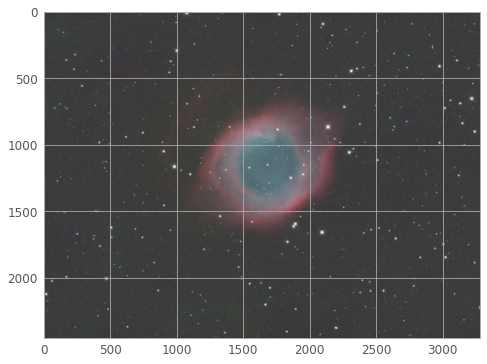

In [75]:
plt.imshow(HelixHOO)

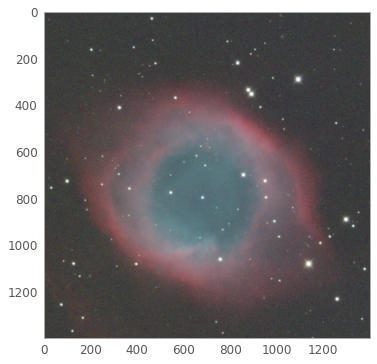

In [42]:
Helix_subset = Helix[500:1900, 1000:2400, :]
plt.imshow(Helix_subset[:,:,0:3])
plt.grid()
plt.show()

In [50]:
thresh = 10
txy = 7
NESMA_Helix = NESMA_filtering_3D(Helix_subset, txy, thresh, verbose=True)

NESMA filtering ... Slice # 0 of 1400
NESMA filtering ... Slice # 50 of 1400
NESMA filtering ... Slice # 100 of 1400
NESMA filtering ... Slice # 150 of 1400
NESMA filtering ... Slice # 200 of 1400
NESMA filtering ... Slice # 250 of 1400
NESMA filtering ... Slice # 300 of 1400
NESMA filtering ... Slice # 350 of 1400
NESMA filtering ... Slice # 400 of 1400
NESMA filtering ... Slice # 450 of 1400
NESMA filtering ... Slice # 500 of 1400
NESMA filtering ... Slice # 550 of 1400
NESMA filtering ... Slice # 600 of 1400
NESMA filtering ... Slice # 650 of 1400
NESMA filtering ... Slice # 700 of 1400
NESMA filtering ... Slice # 750 of 1400
NESMA filtering ... Slice # 800 of 1400
NESMA filtering ... Slice # 850 of 1400
NESMA filtering ... Slice # 900 of 1400
NESMA filtering ... Slice # 950 of 1400
NESMA filtering ... Slice # 1000 of 1400
NESMA filtering ... Slice # 1050 of 1400
NESMA filtering ... Slice # 1100 of 1400
NESMA filtering ... Slice # 1150 of 1400
NESMA filtering ... Slice # 1200 of 140

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


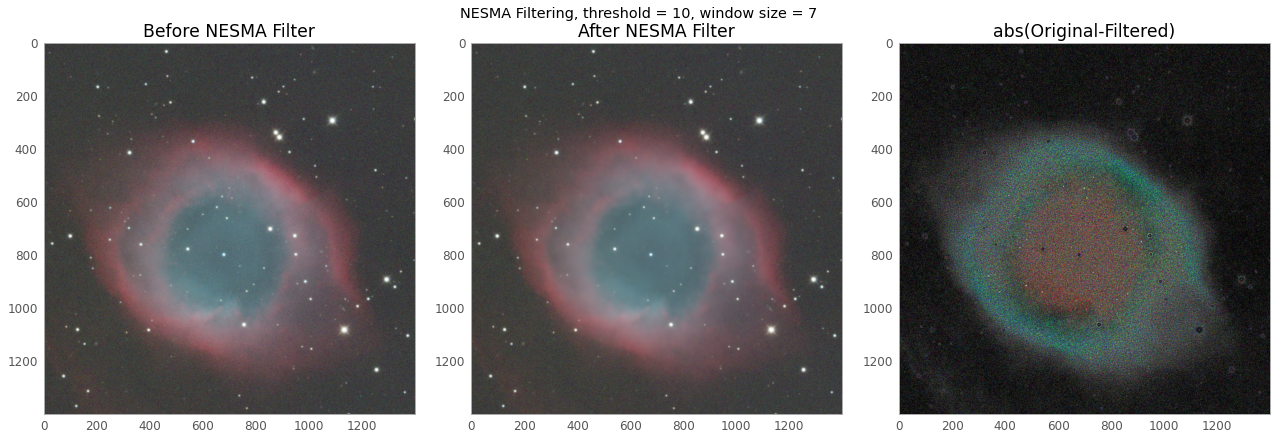

In [51]:
difference = abs(Helix_subset-NESMA_Helix)
difference = 2*10**6*(difference/difference.sum())

fig, ax = plt.subplots(1,3, figsize = (18, 6), tight_layout=True)
fig.suptitle('NESMA Filtering, threshold = %s, window size = %s' % (thresh, txy))
ax[0].imshow(Helix_subset[:,:,0:3])
ax[0].set_title('Before NESMA Filter')
ax[0].grid()
ax[1].imshow(NESMA_Helix[:,:,0:3])
ax[1].set_title('After NESMA Filter')
ax[1].grid()
ax[2].imshow((difference[:,:,0:3]))
ax[2].set_title('abs(Original-Filtered)')
ax[2].grid()
plt.show()